In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

from envelope_detector import HilbertAmplitudeLayer, HilbertLayer

# FilterHilbertLayer

In [13]:
class SincFilter1D(nn.Module):
    def __init__(self, n_channels, kernel_size, srate, fmin_init, fmax_init, bandwidth=None, seed=None):
        super().__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.bandwidth = bandwidth
        self.srate = srate
                
        self.register_buffer('_hamming_window', torch.hamming_window(self.kernel_size).reshape((1,1,-1)))
        self.register_buffer('_scale', torch.arange(-self.kernel_size//2 + 1, self.kernel_size//2 + 1).reshape((1,1,-1)) / self.srate)

        coef_freq = self._create_parameters_freq(self.n_channels, fmin_init, fmax_init, srate=self.srate, seed=seed)
        self.coef_freq = nn.Parameter(coef_freq)
        
        self.bandwidth = bandwidth
        if bandwidth is None:
            coef_bandwidth = self._create_parameters_bandwidth(self.n_channels, seed=seed)
            self.coef_bandwidth = nn.Parameter(coef_bandwidth)
        

    def _create_parameters_freq(self, n_coef, fmin_init, fmax_init, srate, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        coef = fmin_init + torch.rand(size=(n_coef,)) * (fmax_init - fmin_init)
        return coef
    
    def _create_parameters_bandwidth(self, n_coef, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        coef = torch.rand(size=(n_coef,))
        coef = torch.log(coef / (1-coef))
        return coef
    
    def create_frequencies(self, freq=None, bandwidth=None):
        if freq is None:
            freq = F.softplus(self.coef_freq)
        if bandwidth is None:
            bandwidth = torch.sigmoid(self.coef_bandwidth)
        if not isinstance(bandwidth, torch.Tensor):
            bandwidth = torch.tensor(bandwidth, dtype=torch.float32).repeat(*freq.shape)

        freq_low = (freq * (1 - bandwidth / 2)).reshape((-1,1,1))
        freq_high = (freq * (1 + bandwidth / 2)).reshape((-1,1,1))
        return freq, bandwidth, freq_low, freq_high


    def create_filters(self, freq_low=None, freq_high=None):
        if freq_low is None or freq_high is None:
            _, _, freq_low, freq_high = self.create_frequencies(bandwidth=self.bandwidth)
        filt_low = freq_low * torch.special.sinc(2 * freq_low * self._scale)
        filt_high = freq_high * torch.special.sinc(2 * freq_high * self._scale)
        filt = self._hamming_window * 2 * (filt_high - filt_low) / self.srate
        return filt
    
    def forward(self, x):
        filt = self.create_filters()
        x = F.conv1d(x, filt, groups=x.shape[-2], padding='valid')
        return x

In [14]:
class FilterHilbertLayer(nn.Module):
    def __init__(self, n_channels, kernel_size, srate, fmin_init, fmax_init, bandwidth, padding_mode='zeros', seed=None):
        super().__init__()
        
        self.padding = kernel_size // 2
        if padding_mode == 'zeros':
            self.pad = nn.ConstantPad1d(2*self.padding, 0)
        elif padding_mode == 'reflect':
            self.pad = nn.ReflectionPad1d(2*self.padding)
            
        self.temporal_filter = SincFilter1D(n_channels, kernel_size, srate, fmin_init, fmax_init, bandwidth, seed=seed)
        self.hilbert = HilbertLayer()

    def forward(self, x, return_filtered=False):
        ndim = x.ndim
        if ndim == 1:
            x = x.unsqueeze(0).unsqueeze(0)
        elif ndim == 2:
            x = x.unsqueeze(0)
            
        x = self.pad(x)
        x = self.temporal_filter(x)
        x = x[...,self.padding:-self.padding]
            
        if ndim == 1:
            x = x.squeeze(0).squeeze(0)
        elif ndim == 2:
            x = x.squeeze(0)
            
        if return_filtered:
            return x
        
        x = self.hilbert(x)
        x_abs = torch.abs(x)
        return x_abs

In [15]:
torch.manual_seed(1)

srate = 1000
n_channels = 10
# bandwidth = None
bandwidth = 0.4
x = torch.randn(size=(n_channels, 3000,))

filter_hilbert = FilterHilbertLayer(
    n_channels=n_channels,
    kernel_size=251,
    srate=srate,
    fmin_init=40,
    fmax_init=150,
    bandwidth=bandwidth,
)

y_ = filter_hilbert(x, return_filtered=True)
y = filter_hilbert(x)

y.mean().backward()
filter_hilbert.temporal_filter.coef_freq.grad

tensor([ 5.0679e-04,  1.0461e-04,  2.5992e-04,  2.9894e-04,  3.9880e-04,
        -9.1142e-05,  1.0843e-04,  3.1029e-04,  3.6783e-04,  4.5618e-04])

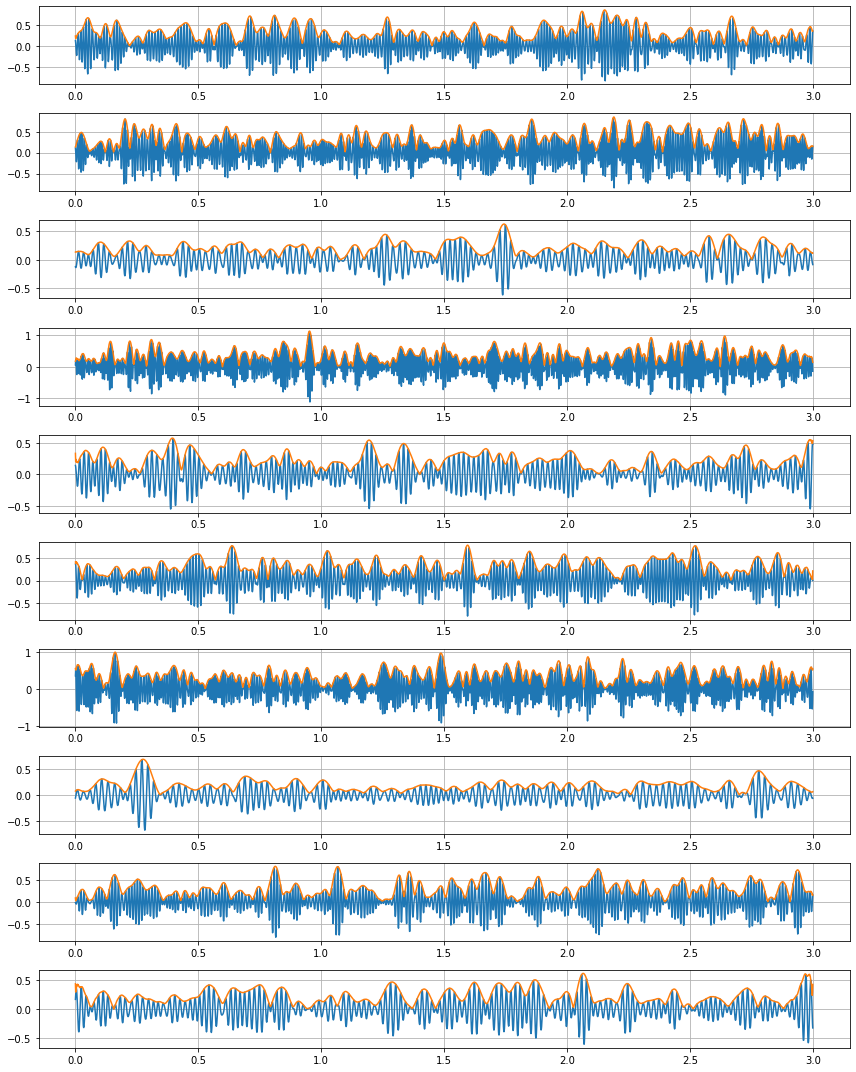

In [16]:
x_numpy = x.numpy()
y_numpy_ = y_.detach().numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy_[i])
    ax[i].plot(scale, y_numpy[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

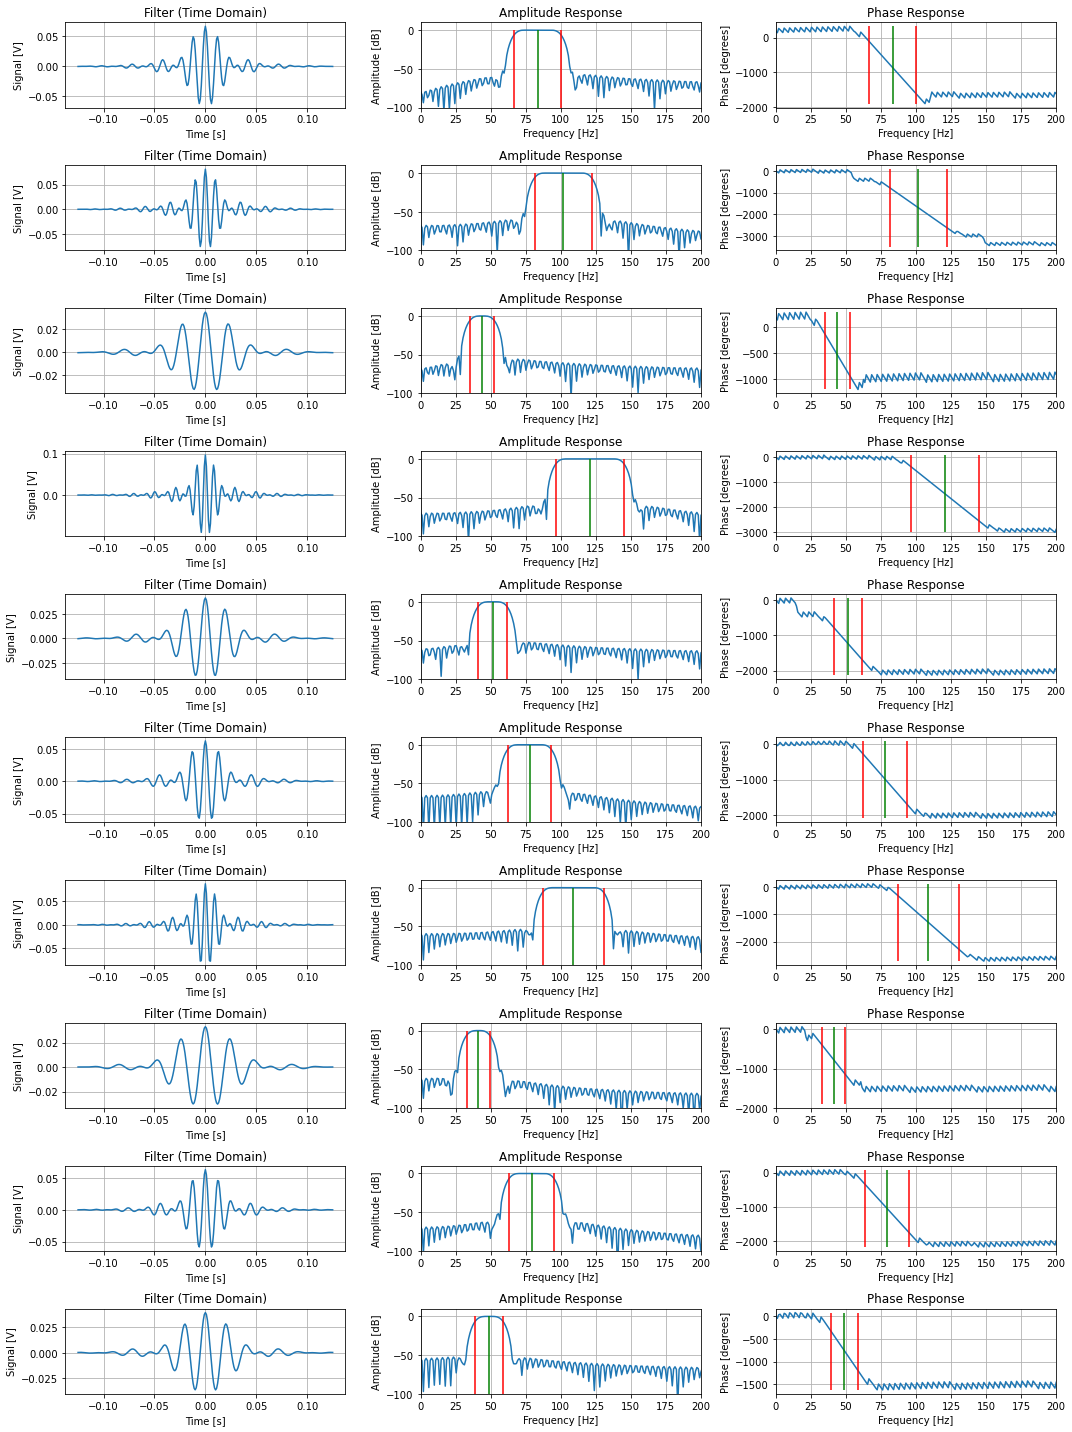

In [17]:
freqs, _, freq_low, freq_high = filter_hilbert.temporal_filter.create_frequencies(bandwidth=bandwidth)
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()
filt = filter_hilbert.temporal_filter.create_filters().detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 2*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0]
    w, h = sg.freqz(filter_coeffs, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20 * np.log10(np.abs(h))
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
    
    
    ax[i,0].plot(filter_hilbert.temporal_filter._scale.numpy()[0,0], filter_coeffs)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
plt.show()

# ComplexWaveletLayer

In [18]:
class ComplexWaveletLayer(nn.Module):
    def __init__(self, n_channels, kernel_size, srate, fmin_init, fmax_init, bandwidth=None, padding_mode='zeros', seed=None):
        super().__init__()
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.bandwidth = bandwidth
        self.srate = srate
        
        self.padding = kernel_size // 2
        if padding_mode == 'zeros':
            self.pad = nn.ConstantPad1d(2*self.padding, 0)
        elif padding_mode == 'reflect':
            self.pad = nn.ReflectionPad1d(2*self.padding)
        
#         self.register_buffer('_scale', torch.arange(-self.kernel_size//2 + 1, self.kernel_size//2 + 1).reshape((1,1,-1)) / self.srate)
        self.register_buffer('_scale', torch.arange(-self.kernel_size//2 + 1, self.kernel_size//2 + 1).reshape((1,1,-1)) / self.srate)


        coef_freq = self._create_parameters_freq(self.n_channels, fmin_init, fmax_init, srate=self.srate, seed=seed)
        self.coef_freq = nn.Parameter(coef_freq)
        
        self.bandwidth = bandwidth
        if bandwidth is None:
            coef_bandwidth = self._create_parameters_bandwidth(self.n_channels, seed=seed)
            self.coef_bandwidth = nn.Parameter(coef_bandwidth)

        
    def _create_parameters_freq(self, n_coef, fmin_init, fmax_init, srate, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        coef = fmin_init + torch.rand(size=(n_coef,)) * (fmax_init - fmin_init)
        return coef

    def _create_parameters_bandwidth(self, n_coef, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        coef = torch.rand(size=(n_coef,))
        coef = torch.log(coef / (1-coef))
        return coef
    
    def create_frequencies(self, freq=None, bandwidth=None):
        if freq is None:
            freq = F.softplus(self.coef_freq)
        if bandwidth is None:
            bandwidth = torch.sigmoid(self.coef_bandwidth)
        if not isinstance(bandwidth, torch.Tensor):
            bandwidth = torch.tensor(bandwidth, dtype=torch.float32).repeat(*freq.shape)

        freq_low = (freq * (1 - bandwidth / 2)).reshape((-1,1,1))
        freq_high = (freq * (1 + bandwidth / 2)).reshape((-1,1,1))
        return freq, bandwidth, freq_low, freq_high
                            
    def create_filters(self, freq=None, bandwidth=None):
        freq, bandwidth, _, _ = self.create_frequencies(freq, bandwidth)
        freq = freq.reshape((-1,1,1))
        bandwidth_ = bandwidth.reshape((-1,1,1)) * freq
        
        sigma2 = (2 * math.log(2)) / (bandwidth_ * math.pi)**2
        filt = (2 * math.pi * sigma2)**(-1/2) / (self.srate / 2)
        filt = filt * (torch.exp(1j*2*math.pi * freq * self._scale) - torch.exp(-0.5*(2*math.pi * freq)**2))
        filt = filt * torch.exp(- self._scale**2 / (2 * sigma2))
        return filt

                            
    def forward(self, x, return_filtered=False):
        ndim = x.ndim
        if ndim == 1:
            x = x.unsqueeze(0).unsqueeze(0)
        elif ndim == 2:
            x = x.unsqueeze(0)
            
        x = self.pad(x)
                            
        x = x.to(torch.complex64)
        filt = self.create_filters(bandwidth=self.bandwidth)
        x = F.conv1d(x, filt, groups=x.shape[-2], padding='valid') * (1 / self.srate)
                            
        x = x[...,self.padding:-self.padding]
            
        if ndim == 1:
            x = x.squeeze(0).squeeze(0)
        elif ndim == 2:
            x = x.squeeze(0)
            
        if return_filtered:
            return torch.real(x)
        else:
            return torch.abs(x)

In [19]:
torch.manual_seed(0)

srate = 1000
n_channels = 10
# bandwidth = None
bandwidth = 0.4
x = torch.randn(size=(n_channels, 3000,))

complex_wavelet = ComplexWaveletLayer(
    n_channels=n_channels,
    kernel_size=251,
    srate=srate,
    fmin_init=40,
    fmax_init=150,
    bandwidth=bandwidth,
)

y_ = complex_wavelet(x, return_filtered=True)
y = complex_wavelet(x)

y.mean().backward()
complex_wavelet.coef_freq.grad

tensor([1.1613e-07, 1.1817e-07, 1.2802e-07, 4.6368e-08, 2.3335e-07, 1.3820e-07,
        3.3333e-07, 2.1775e-07, 2.0104e-07, 1.2416e-07])

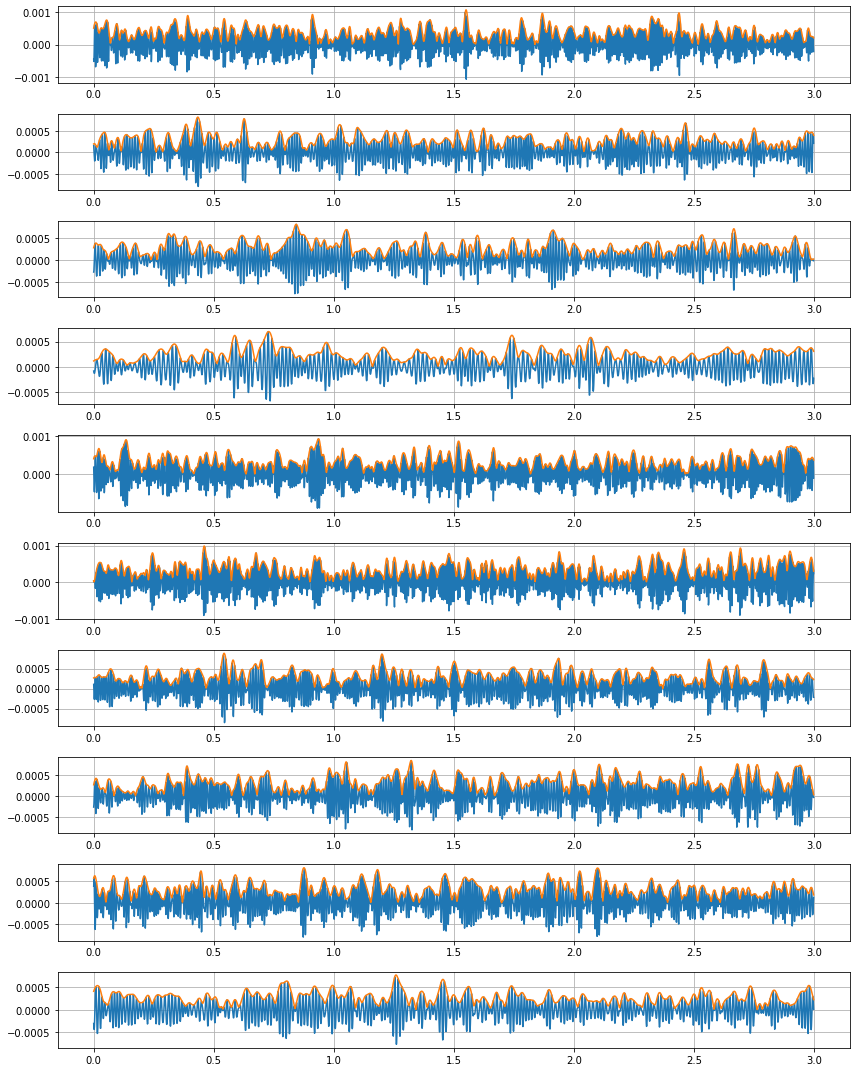

In [20]:
x_numpy = x.numpy()
y_numpy_ = y_.detach().numpy()
y_numpy = y.detach().numpy()
scale = np.arange(x_numpy.shape[-1]) / srate

fig, ax = plt.subplots(n_channels, 1, figsize=(12, 1.5*n_channels))
for i in range(n_channels):
    
    ax[i].plot(scale, y_numpy_[i])
    ax[i].plot(scale, y_numpy[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].grid(True)
    
plt.tight_layout()
plt.show()

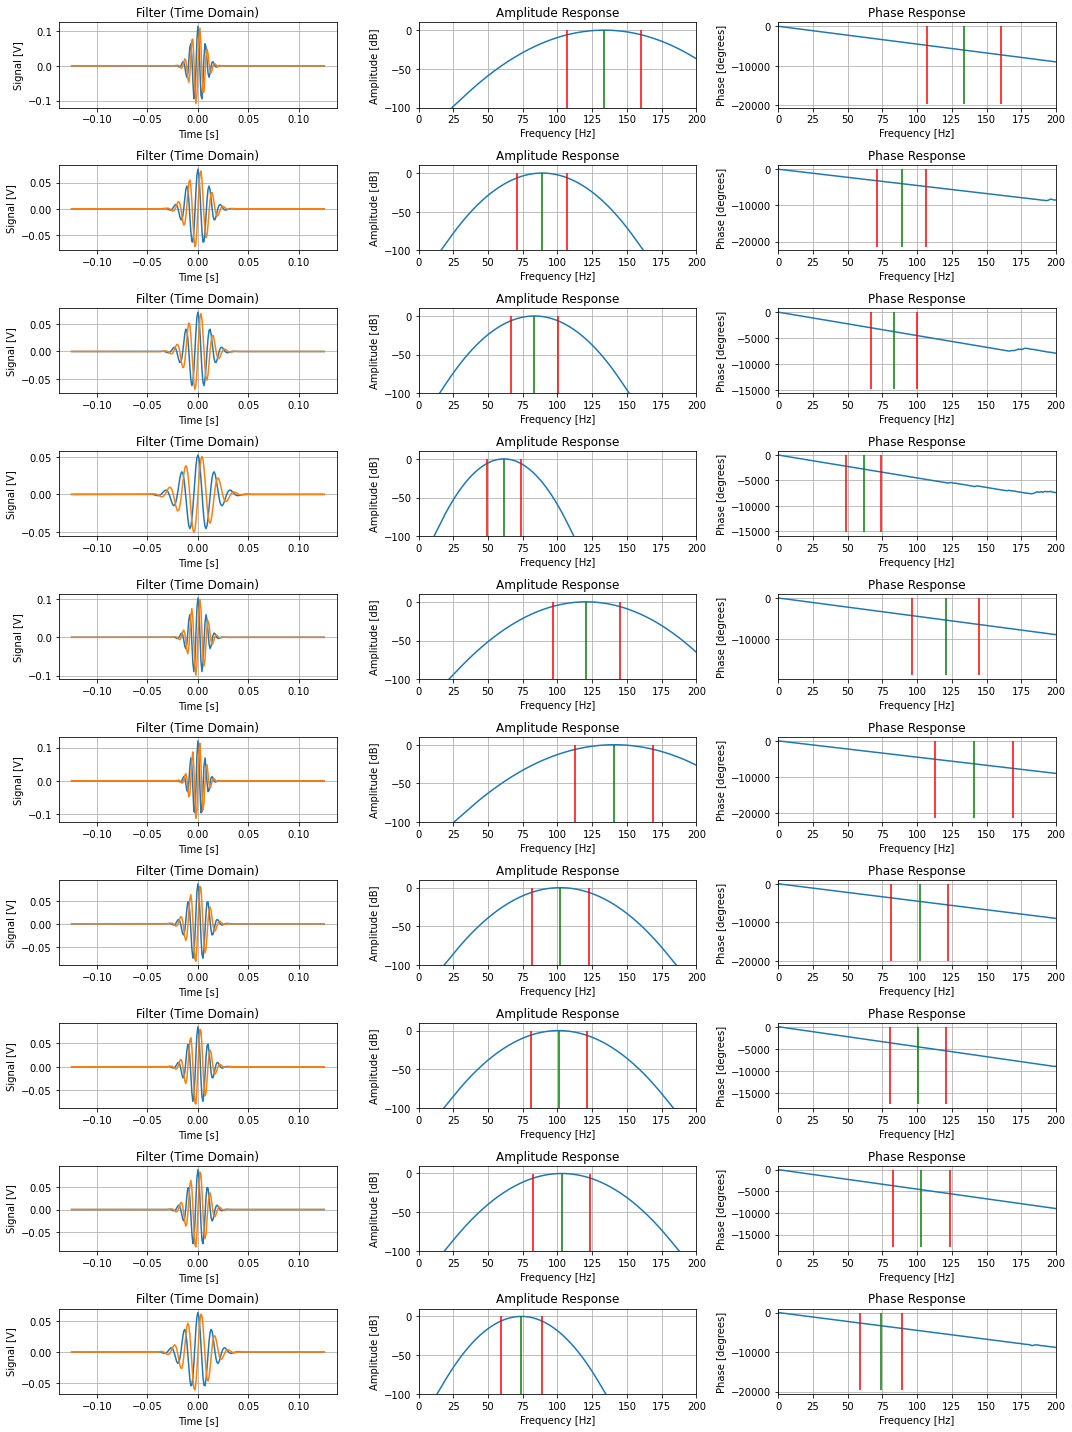

In [24]:
freqs, _, freq_low, freq_high = complex_wavelet.create_frequencies(bandwidth=bandwidth)
freqs, freq_low, freq_high = freqs.detach().numpy(), freq_low.detach().numpy(), freq_high.detach().numpy()
filt = complex_wavelet.create_filters(bandwidth=bandwidth).detach().numpy()

fig, ax = plt.subplots(n_channels, 3, figsize=(15, 2*n_channels))
for i in range(n_channels):
    filter_coeffs = filt[i,0]
    w, h = sg.freqz(filter_coeffs.real, fs=srate * 2 * math.pi)
    freq = w / (2 * math.pi)
    amp = 20*np.log10(np.abs(h) + 1e-6)
#     amp = np.abs(h)
    phase = np.unwrap(np.angle(h)) * 180 / math.pi
#     print(np.sum(amp > amp.max()/2) / freq[1] / freqs[0,0,0])
    
    ax[i,0].plot(complex_wavelet._scale.numpy()[0,0], filter_coeffs.real)
    ax[i,0].plot(complex_wavelet._scale.numpy()[0,0], filter_coeffs.imag)
    ax[i,0].set_ylabel('Signal [V]')
    ax[i,0].set_xlabel('Time [s]')
    ax[i,0].set_title('Filter (Time Domain)')
    ax[i,0].grid(True)
    
    ax[i,1].plot(freq, amp)
    ax[i,1].vlines(freqs[i], np.min(amp), np.max(amp), colors='g')
    ax[i,1].vlines(freq_low[i], np.min(amp), np.max(amp), colors='r')
    ax[i,1].vlines(freq_high[i], np.min(amp), np.max(amp), colors='r')
#     ax[i,1].set_ylim(0, 1)
    ax[i,1].set_ylim(-100, 10)
    ax[i,1].set_xlim(0, 200)
    ax[i,1].set_ylabel('Amplitude [dB]')
    ax[i,1].set_xlabel('Frequency [Hz]')
    ax[i,1].set_title('Amplitude Response')
    ax[i,1].grid(True)
    
    ax[i,2].plot(freq, phase)
    ax[i,2].vlines(freqs[i], np.min(phase), np.max(phase), colors='g')
    ax[i,2].vlines(freq_low[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].vlines(freq_high[i], np.min(phase), np.max(phase), colors='r')
    ax[i,2].set_xlim(0, 200)
    ax[i,2].set_xlabel('Frequency [Hz]')
    ax[i,2].set_ylabel('Phase [degrees]')
    ax[i,2].set_title('Phase Response')
    ax[i,2].grid(True)
    
plt.tight_layout()
plt.show()